COVID-19 Data Analysis using Confirmed & Deaths Datasets

Step 1: Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Step 2: Load Datasets

In [4]:
# Load both datasets
confirmed = pd.read_csv('covid19_Confirmed_dataset.csv')
deaths = pd.read_csv('covid19_deaths_dataset.csv')

# Display first few rows
print("Confirmed Cases Dataset:")
display(confirmed.head())

print("\nDeaths Dataset:")
display(deaths.head())


Confirmed Cases Dataset:


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,609,634,663,678,712,726,736,750,766,773
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,717,723,723,731,738,738,743,743,743,745
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,24,25,25,25,25,26,27,27,27,27



Deaths Dataset:


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,36,40,42,43,47,50,57,58,60,64
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,26,27,27,27,27,28,28,30,30,31
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,392,402,407,415,419,425,432,437,444,450
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,37,37,37,40,40,40,40,41,42,42
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [7]:
confirmed.isna().sum()

Province/State    184
Country/Region      0
Lat                 0
Long                0
1/22/20             0
                 ... 
4/26/20             0
4/27/20             0
4/28/20             0
4/29/20             0
4/30/20             0
Length: 104, dtype: int64

Step 3: Data Cleaning & Overview

In [3]:
# Check info
print("Confirmed Data Info:")
confirmed.info()

print("\nDeaths Data Info:")
deaths.info()

# Check missing values
print("\nMissing Values in Confirmed Data:\n", confirmed.isnull().sum())
print("\nMissing Values in Deaths Data:\n", deaths.isnull().sum())

# Fill missing values
confirmed.fillna(0, inplace=True)
deaths.fillna(0, inplace=True)


Confirmed Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Columns: 104 entries, Province/State to 4/30/20
dtypes: float64(2), int64(100), object(2)
memory usage: 216.3+ KB

Deaths Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Columns: 104 entries, Province/State to 4/30/20
dtypes: float64(2), int64(100), object(2)
memory usage: 216.3+ KB

Missing Values in Confirmed Data:
 Province/State    184
Country/Region      0
Lat                 0
Long                0
1/22/20             0
                 ... 
4/26/20             0
4/27/20             0
4/28/20             0
4/29/20             0
4/30/20             0
Length: 104, dtype: int64

Missing Values in Deaths Data:
 Province/State    184
Country/Region      0
Lat                 0
Long                0
1/22/20             0
                 ... 
4/26/20             0
4/27/20             0
4/28/20             0
4/29/20             0
4/30/20             0
Length: 1

Step 4: Group by Country (Sum All Regions)

In [5]:
# Aggregate values country-wise (only numeric columns)
confirmed_country = confirmed.groupby('Country/Region').sum(numeric_only=True)
deaths_country = deaths.groupby('Country/Region').sum(numeric_only=True)

# Drop unnecessary columns if present (like Lat, Long)
confirmed_country.drop(['Lat', 'Long'], axis=1, inplace=True, errors='ignore')
deaths_country.drop(['Lat', 'Long'], axis=1, inplace=True, errors='ignore')

# Display updated data
print("Confirmed Country-level Data:")
display(confirmed_country.head())

print("Deaths Country-level Data:")
display(deaths_country.head())


Confirmed Country-level Data:


,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171
Albania,0,0,0,0,0,0,0,0,0,0,...,609,634,663,678,712,726,736,750,766,773
Algeria,0,0,0,0,0,0,0,0,0,0,...,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006
Andorra,0,0,0,0,0,0,0,0,0,0,...,717,723,723,731,738,738,743,743,743,745
Angola,0,0,0,0,0,0,0,0,0,0,...,24,25,25,25,25,26,27,27,27,27


Deaths Country-level Data:


,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,36,40,42,43,47,50,57,58,60,64
Albania,0,0,0,0,0,0,0,0,0,0,...,26,27,27,27,27,28,28,30,30,31
Algeria,0,0,0,0,0,0,0,0,0,0,...,392,402,407,415,419,425,432,437,444,450
Andorra,0,0,0,0,0,0,0,0,0,0,...,37,37,37,40,40,40,40,41,42,42
Angola,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


Step 5: Total Cases and Deaths

In [6]:
# Calculate total confirmed and deaths per country
total_confirmed = confirmed_country.sum(axis=1)
total_deaths = deaths_country.sum(axis=1)

# Combine into one dataframe
covid_summary = pd.DataFrame({
    'Total Confirmed': total_confirmed,
    'Total Deaths': total_deaths
})

# Sort top 10 countries
top10 = covid_summary.sort_values(by='Total Confirmed', ascending=False).head(10)
top10


,Total Confirmed,Total Deaths
Country/Region,,
US,20606211,1040897
China,6686938,264084
Italy,6139613,760700
Spain,5979474,602739
Germany,4531683,119146
France,4132964,508617
United Kingdom,3206716,468993
Iran,2783401,175694
Turkey,2156983,50568


Step 6: Visualization – Top 10 Countries

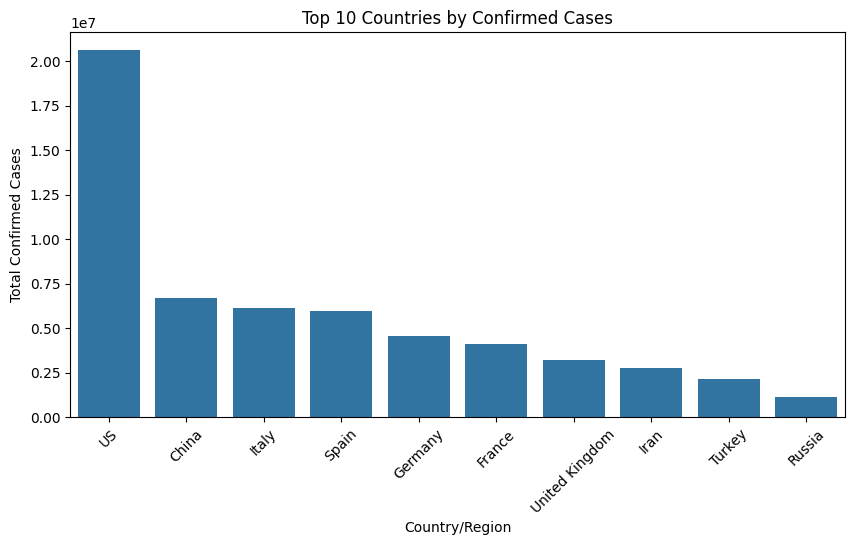

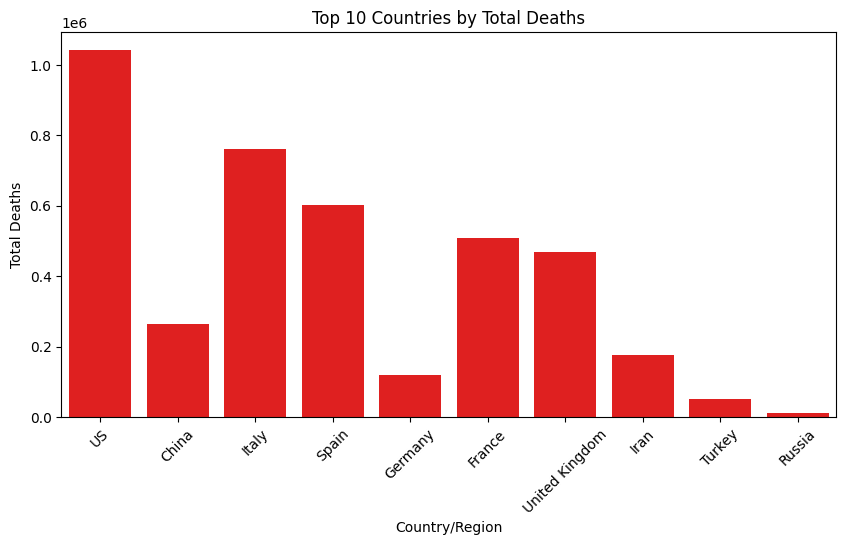

In [7]:
plt.figure(figsize=(10,5))
sns.barplot(x=top10.index, y=top10['Total Confirmed'])
plt.xticks(rotation=45)
plt.title('Top 10 Countries by Confirmed Cases')
plt.ylabel('Total Confirmed Cases')
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x=top10.index, y=top10['Total Deaths'], color='red')
plt.xticks(rotation=45)
plt.title('Top 10 Countries by Total Deaths')
plt.ylabel('Total Deaths')
plt.show()


Step 7: Calculate Death Rate

In [8]:
covid_summary['Death Rate (%)'] = (covid_summary['Total Deaths'] / covid_summary['Total Confirmed']) * 100
covid_summary = covid_summary.sort_values(by='Death Rate (%)', ascending=False)
covid_summary.head(10)


,Total Confirmed,Total Deaths,Death Rate (%)
Country/Region,,,
MS Zaandam,278,60,21.582734
Nicaragua,302,56,18.543046
United Kingdom,3206716,468993,14.625336
Gambia,268,39,14.552239
Zimbabwe,671,95,14.157973
Bahamas,1677,235,14.013119
Algeria,74325,9521,12.809956
Mauritania,250,32,12.800000
Belgium,1082648,135809,12.544151


Step 8: Visualization – Death Rate Comparison

C:\Users\shripad pawar\AppData\Local\Temp\ipykernel_13992\3127374801.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=covid_summary.head(10).index, y=covid_summary.head(10)['Death Rate (%)'], palette='coolwarm')


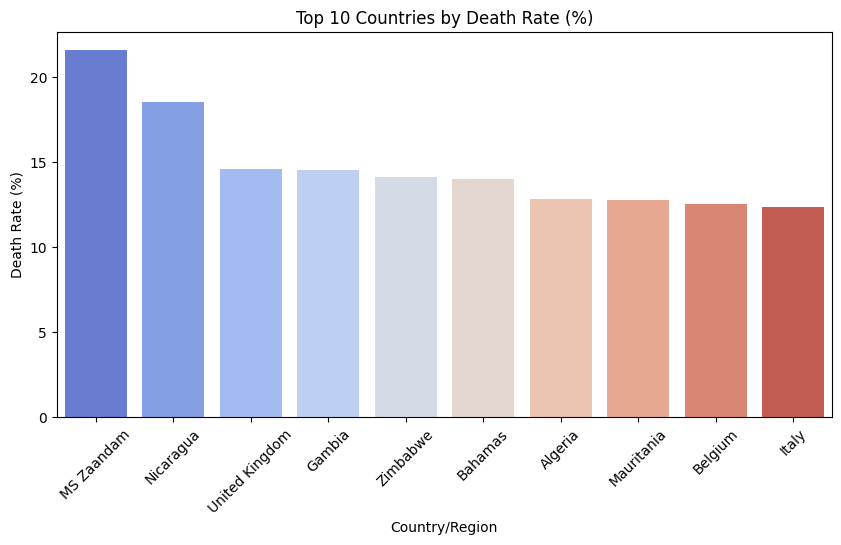

In [9]:
plt.figure(figsize=(10,5))
sns.barplot(x=covid_summary.head(10).index, y=covid_summary.head(10)['Death Rate (%)'], palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Top 10 Countries by Death Rate (%)')
plt.ylabel('Death Rate (%)')
plt.show()


Step 9: Correlation Analysis

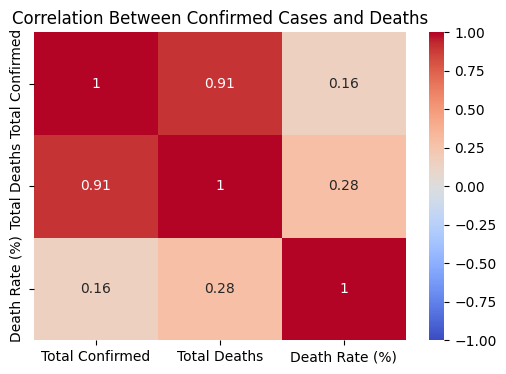

In [10]:
plt.figure(figsize=(6,4))
sns.heatmap(covid_summary.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Confirmed Cases and Deaths')
plt.show()


Step 10: Insights Summary (Markdown Cell)

##  Key Insights:
- The countries with the highest confirmed cases also tend to have the highest deaths.  
- Death rate varies significantly, indicating differences in healthcare quality.  
- There is a **strong positive correlation** between total confirmed and total deaths.  
- Some smaller countries have higher death percentages due to fewer total cases.
